In [7]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sts
import seaborn as sns
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols

from lib.utility_functions import *
from lib.exp4 import *

sns.set_style('white')
sns.set_context('poster')

pd.set_option('display.max_columns', 40)

% matplotlib inline

In [8]:
tidy = pd.read_csv('./tidy_data.csv', index_col=0)

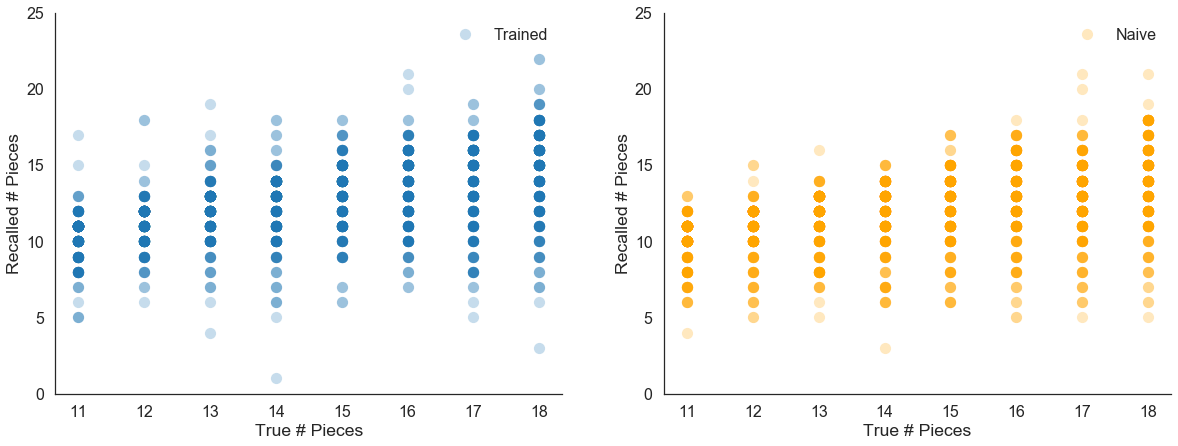

In [21]:
condition_filter = tidy['Condition'] == 'Trained'

fig, axes = plt.subplots(1, 2, figsize=(20, 7))

x = tidy.loc[condition_filter, 'Num Pieces'].values
y = tidy.loc[condition_filter, 'Num Pieces (final)'].values

axes[0].plot(x, y, linestyle='none', marker='o', alpha=.25, label='Trained')
axes[0].legend(loc=0)

x = tidy.loc[~condition_filter, 'Num Pieces'].values
y = tidy.loc[~condition_filter, 'Num Pieces (final)'].values

axes[1].plot(x, y, linestyle='none', marker='o', alpha=.25, color='orange', label='Naive')
axes[1].legend(loc=0)

plt.setp(axes, xlabel='True # Pieces', ylabel='Recalled # Pieces', ylim=[0, 25])

sns.despine()